<a href="https://colab.research.google.com/github/sophie-myk/AIFFEL_quest_cr/blob/main/Exploration/Quest07/250425_cifar10_image_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##0. 모델 고정해서 사용하기
여기서는 고정된 모델 구조를 사용하여 CIFAR-10 데이터셋을 학습합니다.

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        layers.AveragePooling2D((2, 2)),
        layers.BatchNormalization(),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.AveragePooling2D((2, 2)),
        layers.BatchNormalization(),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])
    return model

##1. Data Centric AI 맛보기
이 단계에서는 데이터의 라벨을 수정합니다. labelerrors.com에서 잘못된 라벨이 포함된 인덱스를 찾아 수정합니다.

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
ID 2405 - 수정 전 라벨: 3
ID 2405 - 수정 후 라벨: 6


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54980 (\N{HANGUL SYLLABLE HU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46972 (\N{HANGUL SYLLABLE RA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48296 (\N{HANGUL SYLLABLE BEL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


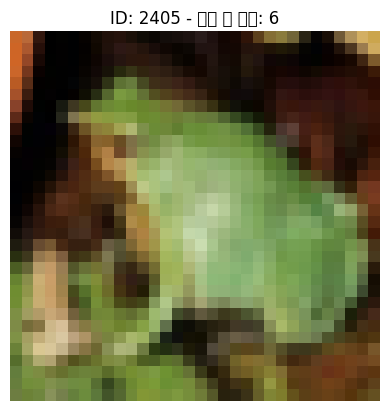

ID 6877 - 수정 전 라벨: 0
ID 6877 - 수정 후 라벨: 8


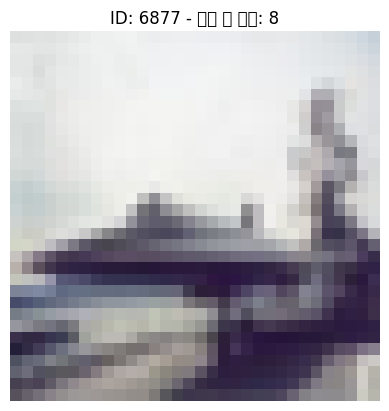

ID 8058 - 수정 전 라벨: 4
ID 8058 - 수정 후 라벨: 7


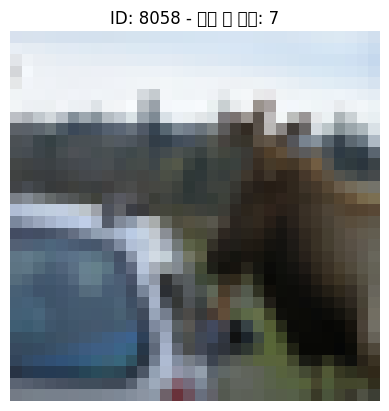

ID 2532 - 수정 전 라벨: 0
ID 2532 - 수정 후 라벨: 1


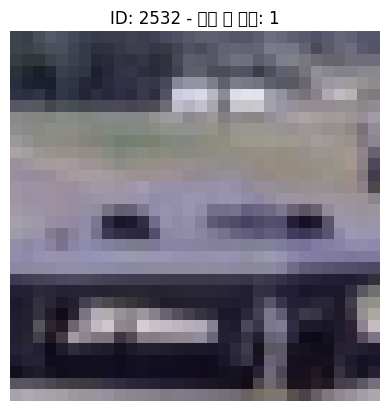

ID 7657 - 수정 전 라벨: 2
ID 7657 - 수정 후 라벨: 8


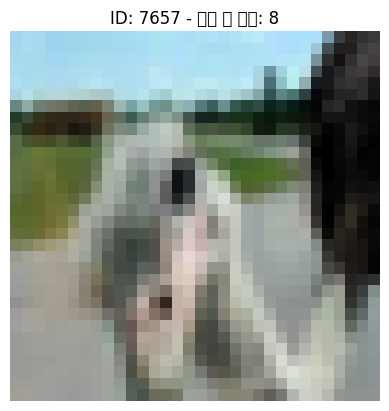

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10

# CIFAR-10 데이터셋 불러오기
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# 잘못된 라벨 인덱스 (예시)
error_indices = [2405, 6877, 8058, 2532, 7657]

# 수정할 ID와 라벨 매핑
corrections = {
    2405: 6, 6877: 8, 8058: 7, 2532: 1, 7657: 8
}

# 각 이미지를 개별적으로 수정하고 시각화
for idx, new_label in corrections.items():
    print(f"ID {idx} - 수정 전 라벨: {y_test[idx][0]}")
    y_test[idx][0] = new_label
    print(f"ID {idx} - 수정 후 라벨: {y_test[idx][0]}")

    plt.imshow(x_test[idx])
    plt.title(f"ID: {idx} - 수정 후 라벨: {new_label}")
    plt.axis('off')
    plt.show()

##2. 하이퍼파라미터 튜닝
Keras Tuner를 사용하여 하이퍼파라미터를 튜닝합니다.

In [4]:
!pip install keras-tuner
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam

def build_model(hp):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        layers.AveragePooling2D((2, 2)),
        layers.BatchNormalization(),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.AveragePooling2D((2, 2)),
        layers.BatchNormalization(),

        layers.Flatten(),
        layers.Dense(hp.Int("dense_units", min_value=128, max_value=512, step=64), activation='relu'),
        layers.Dropout(hp.Float("dropout_rate", min_value=0.3, max_value=0.7, step=0.1)),
        layers.Dense(10, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(hp.Float("learning_rate", 1e-4, 1e-2, sampling="log")),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    directory='my_tuner',
    project_name='cifar10_tuning'
)

# 모델 튜닝 실행
tuner.search(x_train, y_train, epochs=10, validation_split=0.2)
best_model = tuner.get_best_models(num_models=1)[0]

Reloading Tuner from my_tuner/cifar10_tuning/tuner0.json


In [6]:
# 모델 저장 (Keras 네이티브 형식으로 저장)
best_model.save("/content/saved_model/cifar10_model.keras")

In [9]:
import os

# 저장된 모델 경로 확인
os.listdir('/content/saved_model')

['cifar10_model.keras', 'cifar10_model.h5']

In [12]:
import shutil
from google.colab import files

# 모델 파일을 포함하는 디렉토리 압축
shutil.make_archive('/content/cifar10_model', 'zip', '/content/saved_model')

# 압축 파일 다운로드
files.download('/content/cifar10_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
from tensorflow.keras.models import load_model

# 모델 파일 경로 설정
model_path = 'C:/aiffel_sophie/aiffel_MLOps_tuto/cifar10_model/cifar10_model.keras'

# 모델 로드
model = load_model(model_path)

# 모델 구조 확인
model.summary()

ValueError: File not found: filepath=C:/aiffel_sophie/aiffel_MLOps_tuto/cifar10_model/cifar10_model.keras. Please ensure the file is an accessible `.keras` zip file.

In [21]:
import os

# 파일 경로 설정
model_path = 'C:/aiffel_sophie/aiffel_MLOps_tuto/cifar10_model/cifar10_model.keras'  # 또는 .h5

# 파일 존재 여부 확인
print(os.path.exists(model_path))  # True이면 파일이 존재함

False


In [25]:
import os

# 모델 파일 경로 설정 (역슬래시 사용)
model_path = 'C:\\aiffel_sophie\\aiffel_MLOps_tuto\\cifar10_model\\cifar10_model.keras'  # 또는 .h5

# 파일 존재 여부 확인
print(os.path.exists(model_path))  # True이면 파일이 존재함

False


In [22]:
import os

# 파일 경로 설정
model_path = 'C:/aiffel_sophie/aiffel_MLOps_tuto/cifar10_model/cifar10_model.h5'  # 또는 .h5

# 파일 존재 여부 확인
print(os.path.exists(model_path))  # True이면 파일이 존재함

False


In [26]:
import os

# 현재 작업 디렉토리 확인
print(os.getcwd())

/content


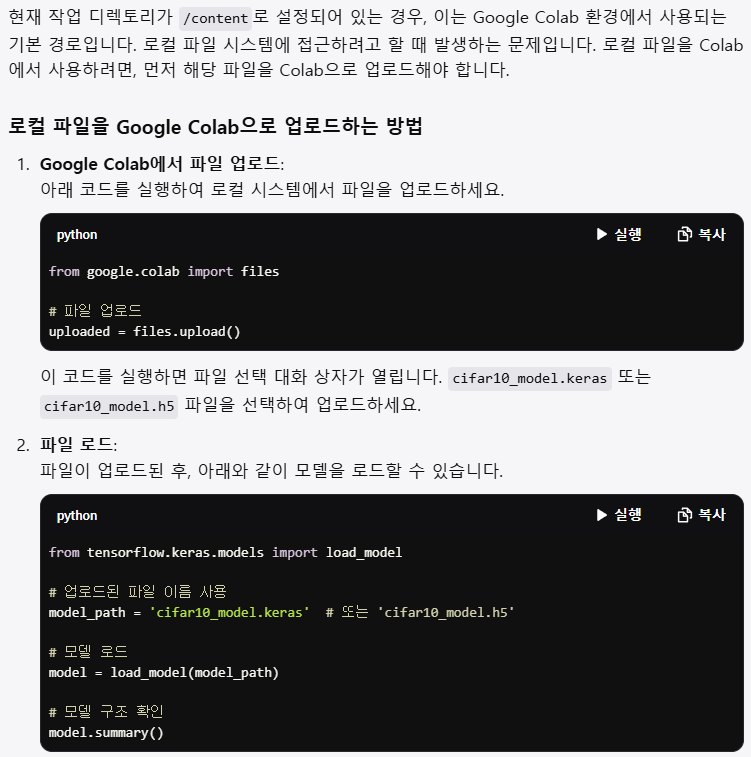<br>
이 과정을 통해 로컬 파일을 Colab환경에서 사용가능함.

In [27]:
from google.colab import files

# 파일 업로드
uploaded = files.upload()

Saving cifar10_model.keras to cifar10_model.keras


In [28]:
from tensorflow.keras.models import load_model

# 업로드된 파일 이름 사용
model_path = 'cifar10_model.keras'  # 또는 'cifar10_model.h5'

# 모델 로드
model = load_model(model_path)

# 모델 구조 확인
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 14 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 15, 15, 32)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 15, 15, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 6, 6, 64)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 6, 6, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 320)            │       737,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         3,210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,520,982 (5.80 MB)

 Trainable params: 760,394 (2.90 MB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 760,396 (2.90 MB)

##데이터 준비
모델을 평가하거나 예측하기 위해 테스트 데이터셋을 준비해야 합니다. CIFAR-10 데이터셋을 사용할 경우, TensorFlow에서 제공하는 데이터셋을 로드할 수 있습니다.

In [30]:
from tensorflow.keras.datasets import cifar10

# CIFAR-10 데이터 로드
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# 데이터 전처리: 정규화
x_test = x_test.astype('float32') / 255.0

##모델 평가
테스트 데이터셋을 사용하여 모델의 성능 평가하기

In [31]:
# 모델 평가
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_accuracy}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.0995 - loss: 6.7915
Test accuracy: 0.10000000149011612


##예측 수행
새로운 데이터를 사용해 예측을 수행하기

In [32]:
# 첫 번째 테스트 이미지에 대한 예측
import numpy as np

predictions = model.predict(x_test[:1])
predicted_class = np.argmax(predictions, axis=1)
print(f'Predicted class: {predicted_class[0]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
Predicted class: 3


##결과 시각화
예측 결과를 시각화하여 어떤 이미지가 어떤 클래스에 속하는지 확인하기

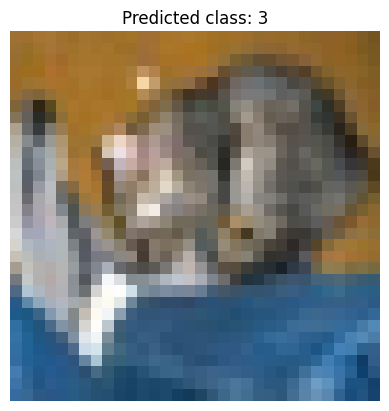

In [33]:
import matplotlib.pyplot as plt

# 이미지와 예측 결과 시각화
plt.imshow(x_test[0])
plt.title(f'Predicted class: {predicted_class[0]}')
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


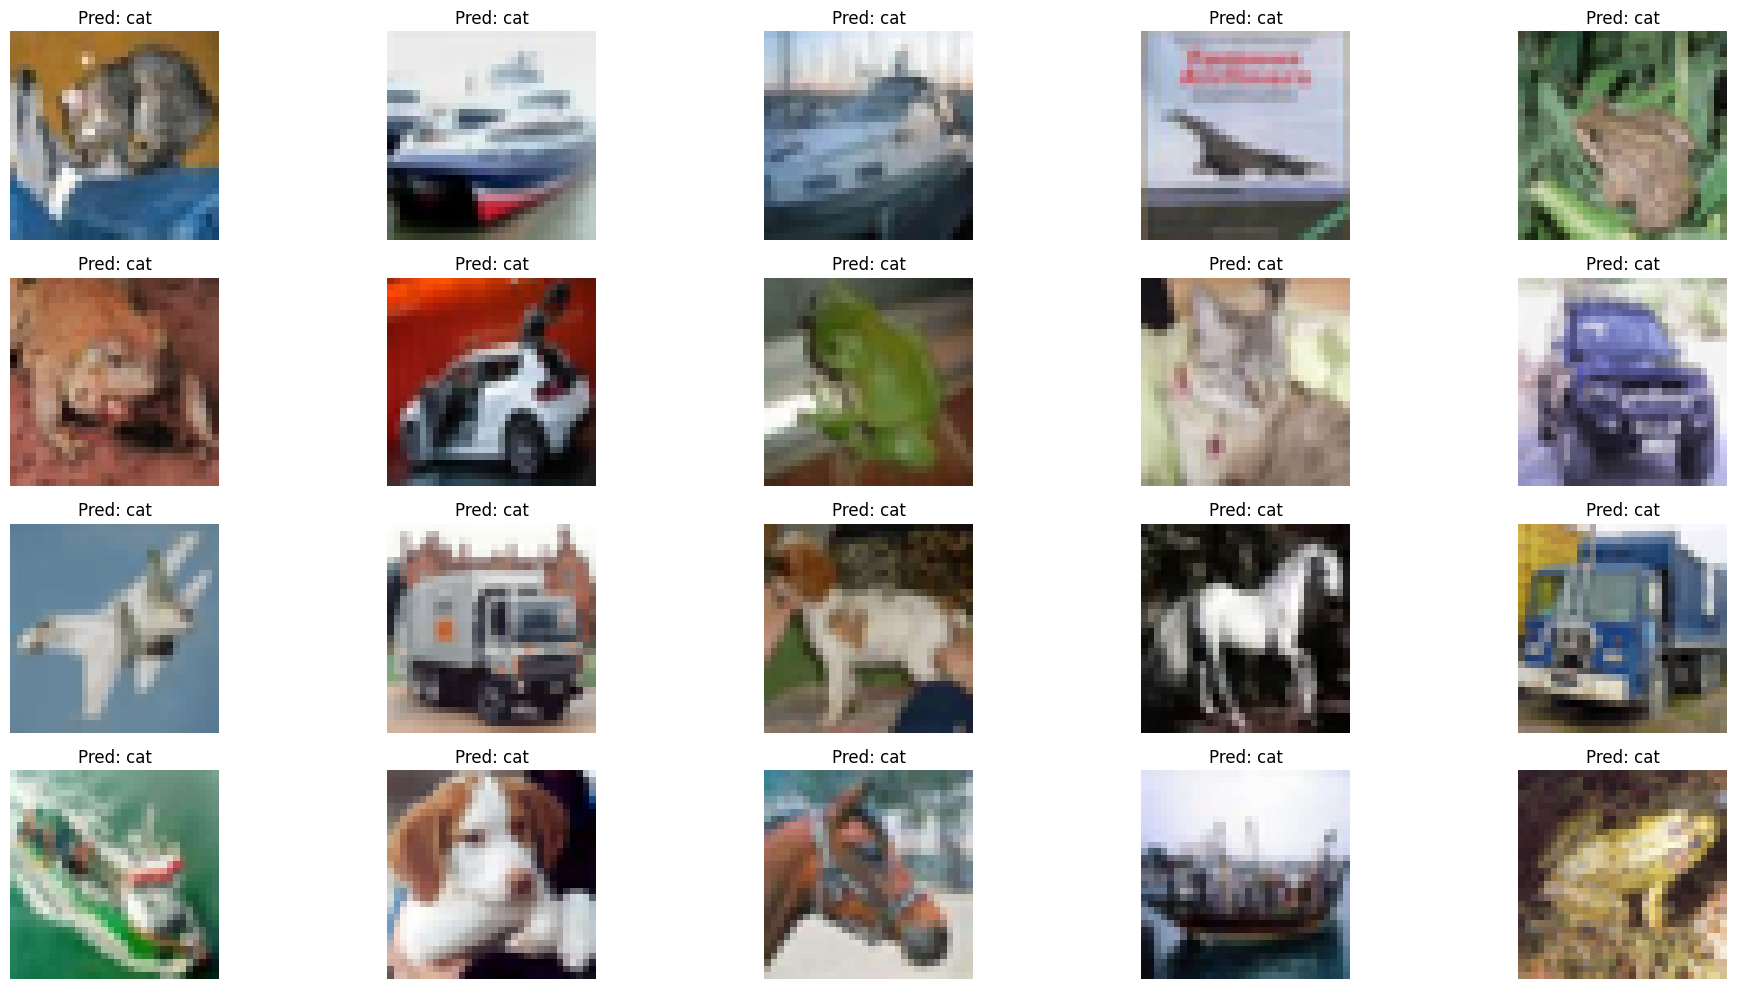

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# 첫 20개 테스트 이미지에 대한 예측
predictions = model.predict(x_test[:20])
predicted_classes = np.argmax(predictions, axis=1)

# 클래스 레이블 정의 (CIFAR-10)
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# 시각화
plt.figure(figsize=(20, 10))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(x_test[i])
    plt.title(f'Pred: {class_labels[predicted_classes[i]]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

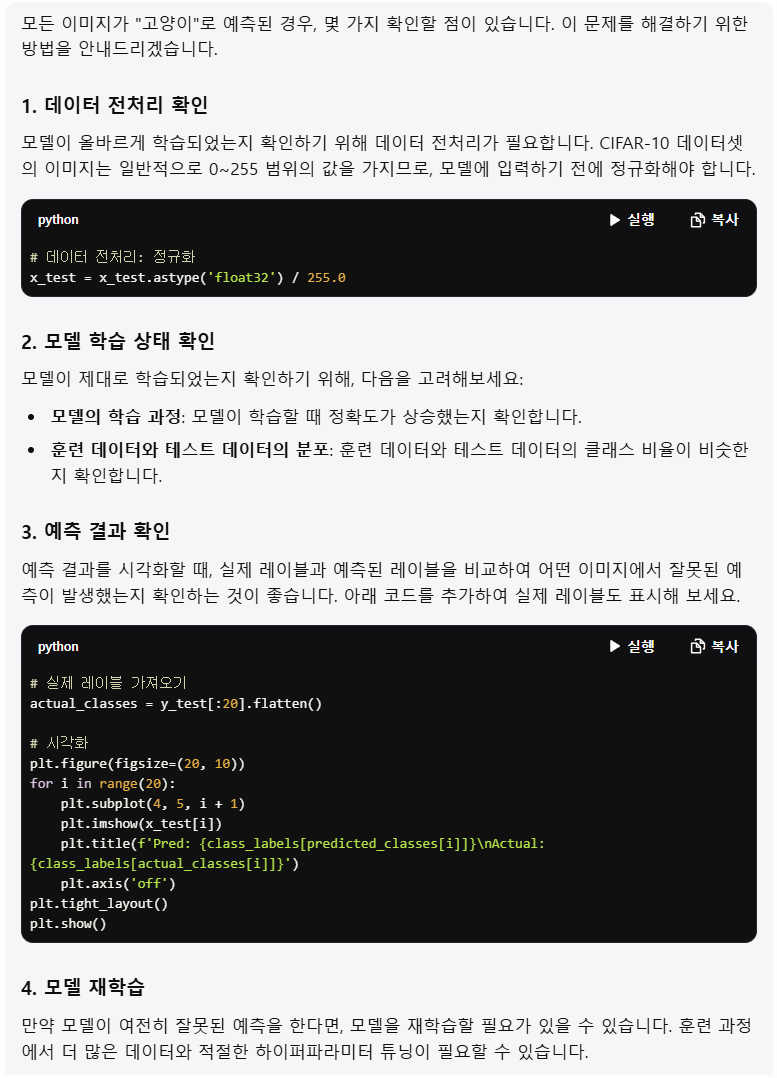

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


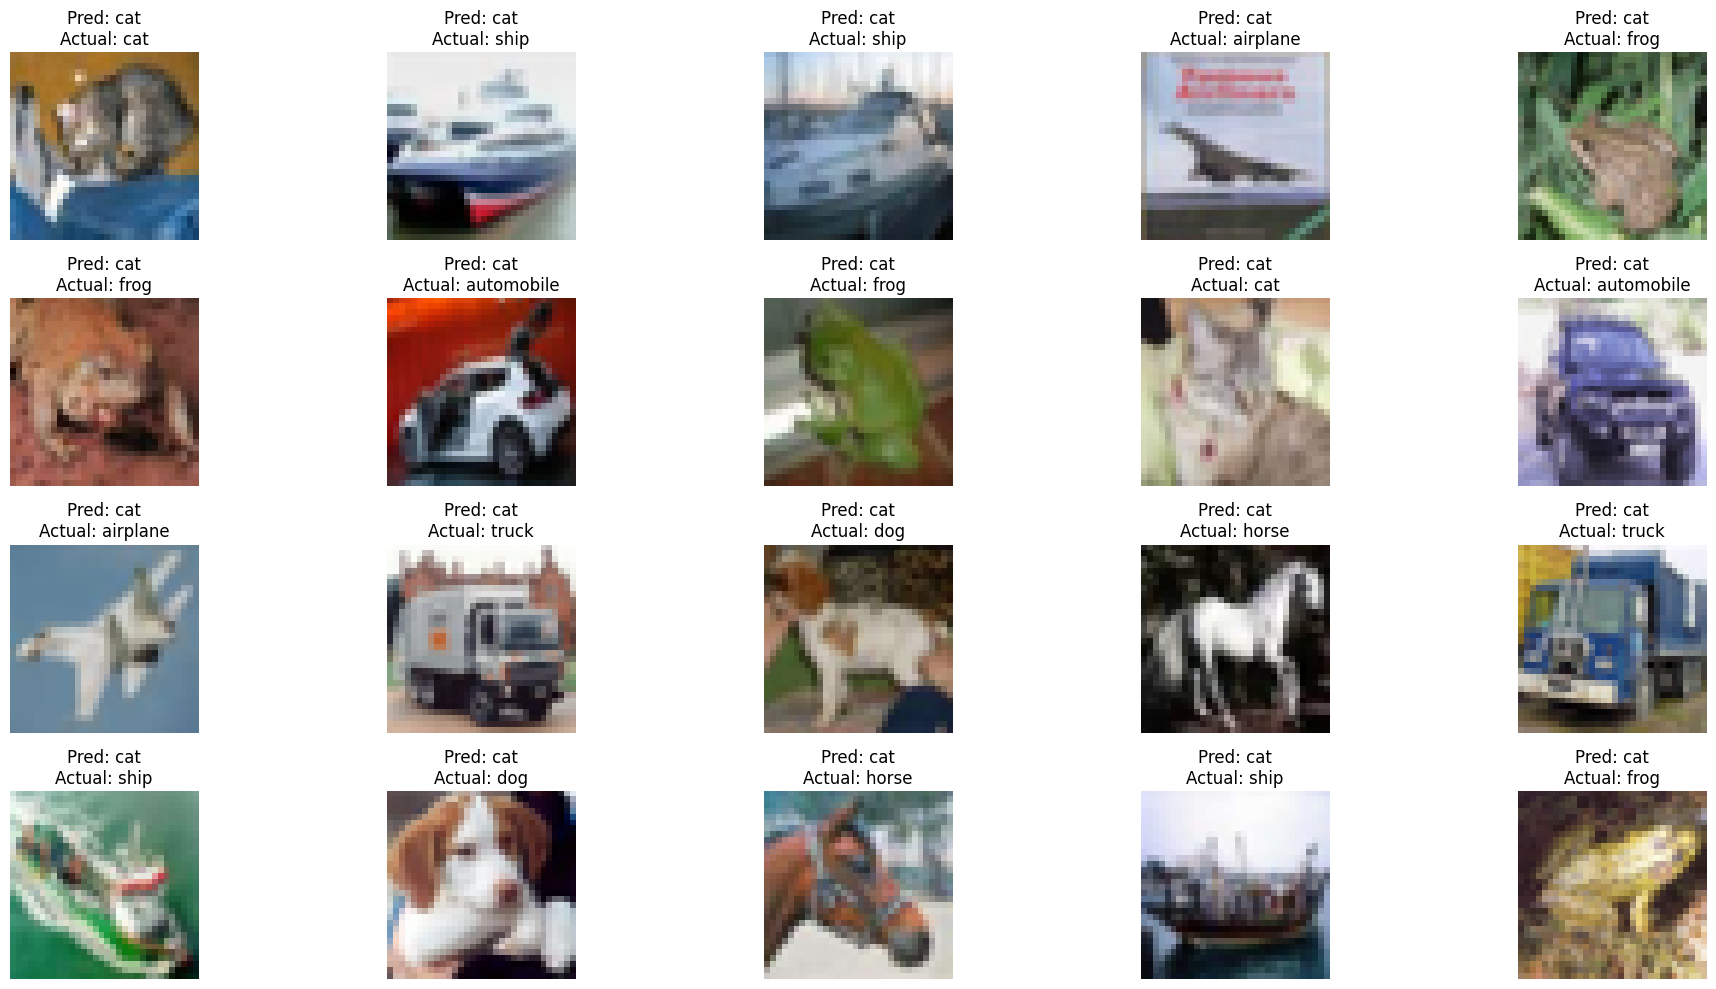

In [35]:
#CIFAR-10 데이터셋을 로드하고, 모델을 평가한 후, 첫 20개의 이미지와 그에 대한 예측 및 실제 레이블을 시각화하는 전체 코드
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.datasets import cifar10

# 모델 파일 경로 설정 (업로드한 파일 이름 사용)
model_path = 'cifar10_model.keras'  # 또는 'cifar10_model.h5'

# 모델 로드
model = load_model(model_path)

# CIFAR-10 데이터 로드
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# 데이터 전처리: 정규화
x_test = x_test.astype('float32') / 255.0

# 첫 20개 테스트 이미지에 대한 예측
predictions = model.predict(x_test[:20])
predicted_classes = np.argmax(predictions, axis=1)

# 실제 레이블 가져오기
actual_classes = y_test[:20].flatten()

# 클래스 레이블 정의 (CIFAR-10)
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# 시각화
plt.figure(figsize=(20, 10))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(x_test[i])
    plt.title(f'Pred: {class_labels[predicted_classes[i]]}\nActual: {class_labels[actual_classes[i]]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

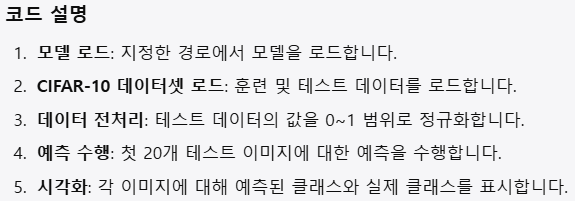

- Pred와 Actual이 다르면 모델의 예측이 부정확하다는 뜻입니다.
- 모델의 성능을 개선하기 위해 데이터셋을 점검하거나 모델을 재학습할 필요가 있을 수 있습니다.
- 혼동 행렬을 통해 어떤 클래스 간에 혼동이 발생하는지 분석할 수 있습니다

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step


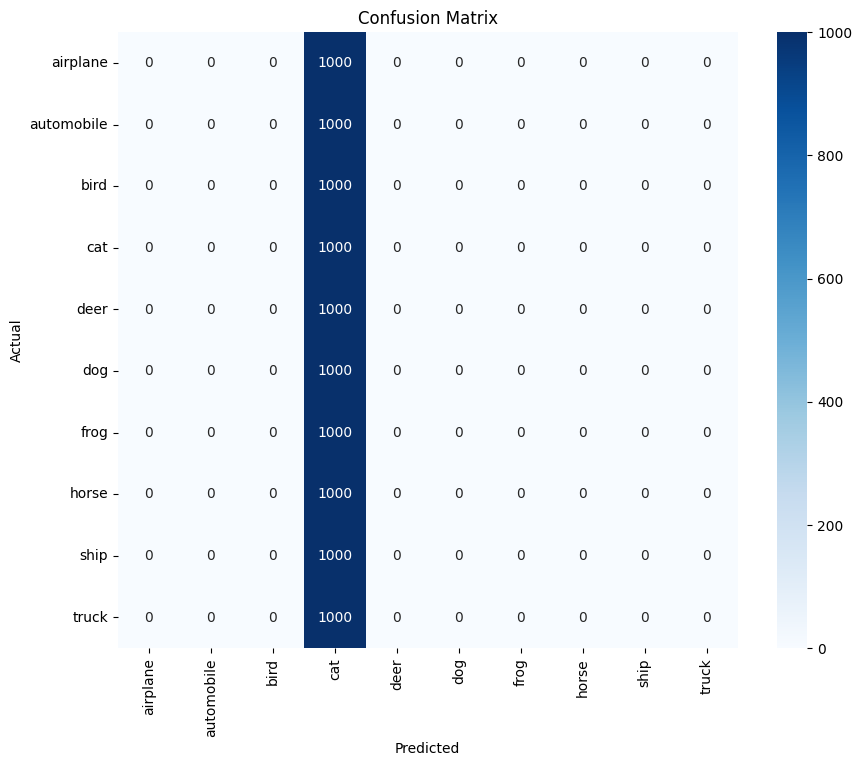

In [36]:
#혼동 행렬을 생성하고 시각화
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 전체 테스트 데이터에 대한 예측
all_predictions = model.predict(x_test)
all_predicted_classes = np.argmax(all_predictions, axis=1)

# 혼동 행렬 생성
cm = confusion_matrix(y_test.flatten(), all_predicted_classes)

# 혼동 행렬 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

모델의 혼동 행렬에서 모든 예측이 "고양이(cat)"로 나타나고 있다는 것은 모델이 "고양이" 클래스에만 매우 높은 확률을 부여하고 있으며, 다른 클래스에 대한 인식이 전혀 이루어지지 않고 있다는 것을 의미합니다.

#해석 방법 <br>
1. 모델의 편향:

모델이 "고양이" 클래스에만 치우친 예측을 하고 있습니다. 이는 훈련 데이터에서 "고양이" 예제가 다른 클래스에 비해 더 많거나, 모델이 "고양이"에 특화된 특성을 과도하게 학습했음을 나타냅니다.

2. 데이터셋 불균형:

훈련 데이터셋의 클래스 분포를 확인해야 합니다. 특정 클래스(여기서는 "고양이")의 데이터가 많고, 다른 클래스의 데이터가 적다면, 모델이 "고양이"를 자주 예측하는 경향이 생길 수 있습니다.

3. 모델의 복잡성 부족:

모델이 충분한 복잡성을 갖추지 못해 다양한 클래스의 특성을 학습하지 못했을 수 있습니다. 더 깊거나 복잡한 모델을 시도해 볼 필요가 있습니다.

#개선 방안 <br>
1. 데이터셋 점검:

각 클래스의 샘플 수를 확인하고, 필요하다면 데이터 증강(data augmentation)을 통해 적은 클래스의 데이터를 늘립니다.

2. 모델 재학습:

모델의 구조를 변경하거나 하이퍼파라미터를 조정하여 모델을 재학습합니다. 예를 들어, 더 많은 레이어를 추가하거나, 오버피팅을 방지하기 위한 정규화 기법을 사용할 수 있습니다.

3. 전이 학습(Transfer Learning):

사전 훈련된 모델을 사용하여 "고양이" 외의 클래스를 학습할 수 있습니다. 이를 통해 더 나은 성능을 얻을 수 있습니다.

4. 혼동 행렬 분석:

모델의 예측이 잘못된 클래스에 대해 추가적인 분석을 진행하여, 어떤 특성이 모델의 예측을 방해하는지 파악합니다.

##후기

너무나 당황스럽게도 전세계의 모든 사물은 '고양이'로 통칭되는 결과값이 나왔다.
잘못 라벨링된 이미지를 재분류하여 제대로 기능할 수 있게 한다는 점은 흥미로왔으나 성공하지 못하였다....
내가 이루고자 하는 과정에서 내가 사용하는 도구가 어떻게 기능하는지 보다 분명히 파악하고 활용하는 연습이 더 필요하겠다. 아자자..!